In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-white")


C:\Users\Kevin\AppData\Local\Temp\ipykernel_5924\1806114291.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


#### 0 a) # c)

<AxesSubplot: xlabel='Minutes', ylabel='SEK'>

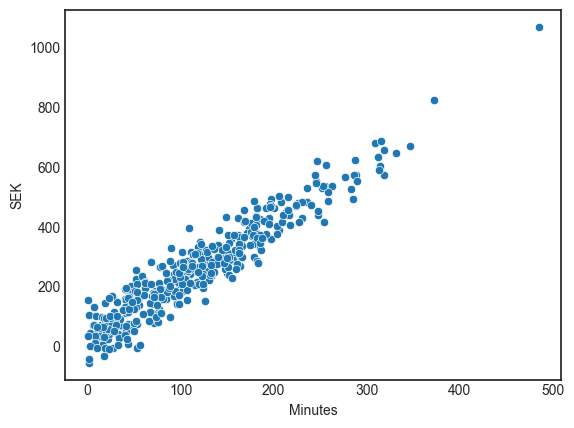

In [132]:
np.random.seed(42)

df = pd.DataFrame()

df['Minutes'] = np.random.normal(100, 100, size=400)
df['Minutes'] = df['Minutes'].abs()

noise = np.random.normal(0, 50, size=400)

df['SEK'] = 2 * df['Minutes'] + 25 + noise


sns.scatterplot(data=df, x=df["Minutes"], y=df['SEK'])

#### 0 b)

<AxesSubplot: xlabel='Minutes', ylabel='SEK'>

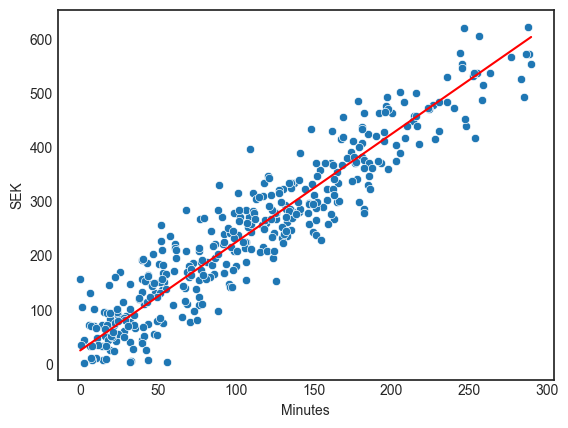

In [159]:
df = df.drop(df[df['Minutes'] > 300].index)
df = df.drop(df[df['SEK'] < 0].index)

sns.scatterplot(data=df, x=df["Minutes"], y=df['SEK'])


x, y = df['Minutes'], df['SEK']
b0 = 25
b1 = 2

y_hat = lambda x: b0 + b1*x

sns.lineplot(data=df, x=df["Minutes"], y=y_hat(x), color='red')
